# Neural Signal Decoding with MLPs on PyTorch

Decoding brain signals using deep learning on the Haxby dataset. Develop, train, and test models within the PyTorch framework. Discover how non-linearities in multilayer perceptrons enhance decoding capabilities for complex cognitive processes.

As we delve into the very essence of our model, we unlock its potential to comprehend and categorize neural signals. Our model learns to distinguish between categories as diverse as "rest," "face," "chair," and others. Each iteration of training breathes life into our data, revealing its predictive prowess and its ability to decipher the profound stories hidden within neural patterns.

*


In [18]:
import os
import numpy as np
import pandas as pd
from nilearn import datasets, image
from nilearn.maskers import NiftiMasker
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings(action='once')

## Loading and Preparing Data

Here, we load subject-specific functional MRI data from the Haxby dataset. We process the data through masking, z-score standardization, and detrending. 

In [3]:
# Load the Haxby dataset
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)

func_file = haxby_dataset.func[0]
mask_filename = haxby_dataset.mask_vt[0]
session_target_file = haxby_dataset.session_target[0]

# Load and inspect the functional MRI data image
func_img = image.load_img(func_file)

# Mask functional MRI data
masker = NiftiMasker(mask_img=mask_filename, standardize='zscore_sample', detrend=True, memory='nilearn_cache')

# Load cognitive annotations
behavioral = pd.read_csv(session_target_file, delimiter=' ')

# Selecting variables
X = masker.fit_transform(func_img)
y = behavioral['labels']

## Data Overview and Analysis

Let's start by examining the sizes of `X` and `y`.

In [6]:
categories = y.unique()
print('')
print("Unique Categories:", categories)
print('')
print("y Shape:", y.shape)
print("X Shape:", X.shape)




Unique Categories: ['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']

y Shape: (1452,)
X Shape: (1452, 675)


## One-Hot Encoding

Convert categorical labels into one-hot encoded format, enabling numeric inputs essential for neural networks. This preprocessing ensures data readiness for analysis and modeling.

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

# Convert the target variable 'y' into one-hot encoded format
y_onehot = enc.fit_transform(y.values.reshape(-1, 1))

# Convert the sparse matrix into a pandas DataFrame
y_encoded = pd.DataFrame(y_onehot.toarray())

# Display the first 10 rows of the one-hot encoded 'y'
display(y_encoded[:10])


,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


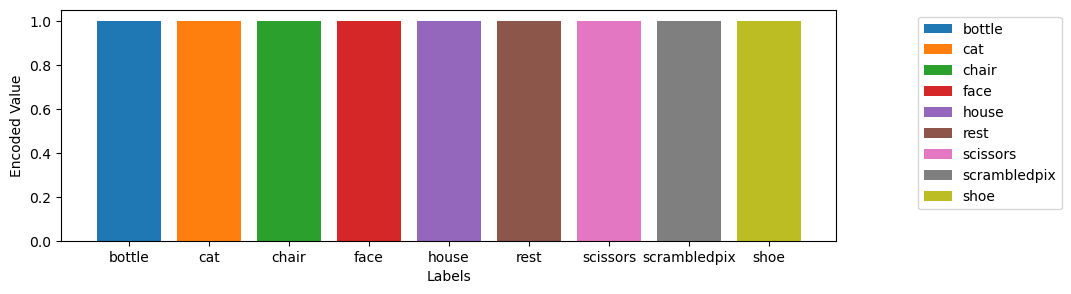

In [25]:
import matplotlib.pyplot as plt


# Plotting one-hot encoded vectors along with their corresponding labels
fig, ax = plt.subplots(figsize=(10, 3))

for idx, label in enumerate(unique_labels):
    ax.bar(idx, 1, label=str(label))
    
ax.set_xticks(range(len(unique_labels)))
ax.set_xticklabels(unique_labels)
ax.set_ylabel('Encoded Value')
ax.set_xlabel('Labels')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)

plt.show()


## Build and Train the Model

In this section, we'll build a simple Multilayer Perceptron (MLP) model using PyTorch to decode brain signals. We'll prepare the data by splitting it into training and test sets and then set up a 10-fold cross-validation for training/validation.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# After one-hot encoding, convert the DataFrame to a NumPy array
y_encoded = y_encoded.to_numpy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

In [32]:
# Define the MLP model architecture
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the dimensions
input_size = X_train.shape[1]
hidden_size = 50  # Adjust as needed
output_size = len(categories)

# Create an instance of the MLP model
model_mlp = MLPModel(input_size, hidden_size, output_size)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters())


In [33]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model_mlp(batch_X)
        loss = criterion(outputs, torch.argmax(batch_y, dim=1))
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
    # Validation
    with torch.no_grad():
        y_pred = model_mlp(X_test_tensor)
        val_loss = criterion(y_pred, torch.argmax(y_test_tensor, dim=1))
        val_acc = accuracy_score(torch.argmax(y_test_tensor, dim=1), torch.argmax(y_pred, dim=1))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/10], Loss: 1.3944, Val Loss: 1.0933, Val Acc: 0.6667
Epoch [2/10], Loss: 0.5969, Val Loss: 0.8710, Val Acc: 0.7320
Epoch [3/10], Loss: 0.0052, Val Loss: 0.7037, Val Acc: 0.7560
Epoch [4/10], Loss: 0.0014, Val Loss: 0.6144, Val Acc: 0.8007
Epoch [5/10], Loss: 0.0207, Val Loss: 0.5550, Val Acc: 0.8385
Epoch [6/10], Loss: 0.0640, Val Loss: 0.5151, Val Acc: 0.8625
Epoch [7/10], Loss: 0.1286, Val Loss: 0.4713, Val Acc: 0.8763
Epoch [8/10], Loss: 0.2741, Val Loss: 0.4708, Val Acc: 0.8694
Epoch [9/10], Loss: 0.0051, Val Loss: 0.4636, Val Acc: 0.8729
Epoch [10/10], Loss: 0.0006, Val Loss: 0.4446, Val Acc: 0.8900


**The model's training process shows a consistent decrease in the loss,** indicating that the model is learning to fit the data better with each epoch. Validation loss also decreases, and validation accuracy consistently improves. These are positive signs that the model is learning and generalizing well to the validation data.

In [36]:

epoch_results = [
    (1, 1.3944, 1.0933, 0.6667),
    (2, 0.5969, 0.8710, 0.7320),
    (3, 0.0052, 0.7037, 0.7560),
    (4, 0.0014, 0.6144, 0.8007),
    (5, 0.0207, 0.5550, 0.8385),
    (6, 0.0640, 0.5151, 0.8625),
    (7, 0.1286, 0.4713, 0.8763),
    (8, 0.2741, 0.4708, 0.8694),
    (9, 0.0051, 0.4636, 0.8729),
    (10, 0.0006, 0.4446, 0.8900)
]

epochs, train_loss, val_loss, val_acc = zip(*epoch_results)

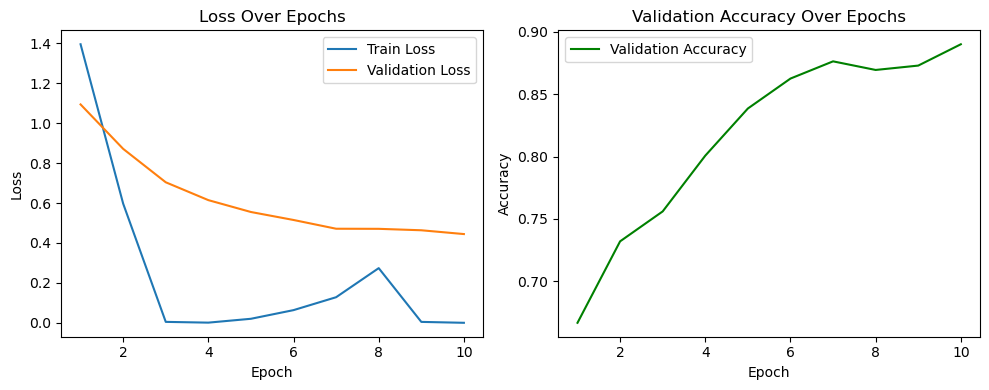

In [37]:


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
from sklearn.metrics import classification_report

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test)

# Get model predictions on the test set
model_mlp.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_test_pred = model_mlp(X_test_tensor)
    
# Convert predictions to numpy arrays
y_test_pred_numpy = y_test_pred.cpu().numpy()
y_test_numpy = y_test_tensor.cpu().numpy()

# Calculate the index with the highest probability as predicted class
y_test_pred_class = y_test_pred_numpy.argmax(axis=1)
y_test_class = y_test_numpy.argmax(axis=1)

# Print classification report
print(classification_report(y_test_class, y_test_pred_class))


              precision    recall  f1-score   support

           0       0.95      0.87      0.91        23
           1       0.89      0.80      0.84        20
           2       0.80      0.89      0.84        18
           3       0.84      1.00      0.92        27
           4       0.94      0.88      0.91        17
           5       0.92      0.91      0.91       117
           6       0.84      0.78      0.81        27
           7       0.94      0.94      0.94        18
           8       0.81      0.88      0.84        24

    accuracy                           0.89       291
   macro avg       0.88      0.88      0.88       291
weighted avg       0.89      0.89      0.89       291



**Performance of the model on the test data:**

- The model achieved an accuracy of 89% on the test set.
- The precision, recall, and F1-score vary across different categories, with higher values for some classes than others.
- The macro average F1-score is 88%, indicating the model's overall performance across all classes.

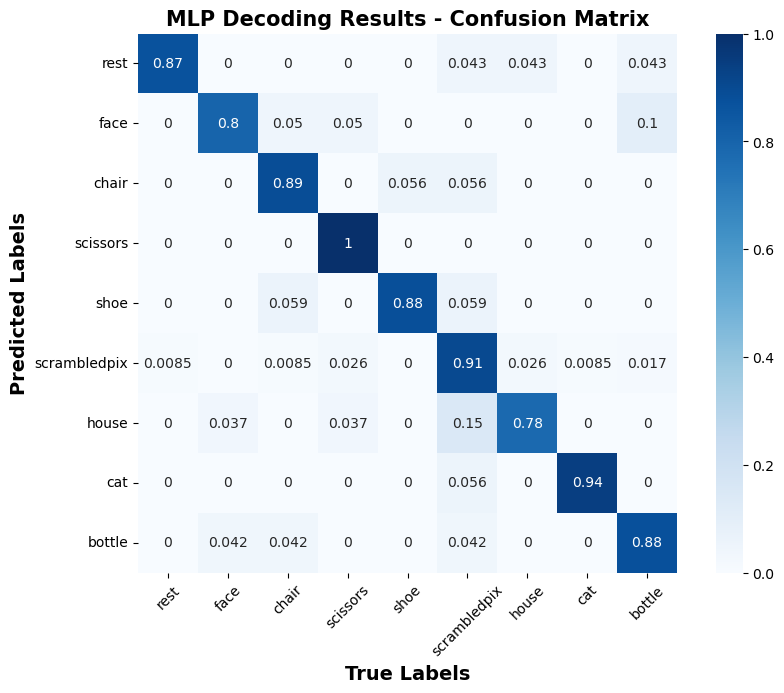

In [39]:
from sklearn.metrics import confusion_matrix


# Convert the PyTorch tensors to numpy arrays
y_test_pred_np = y_test_pred.detach().cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Calculate the confusion matrix
cm_mlp = confusion_matrix(y_test_np.argmax(axis=1), y_test_pred_np.argmax(axis=1))
model_conf_matrix = cm_mlp.astype('float') / cm_mlp.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(model_conf_matrix, index=categories, columns=categories)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues', square=True)
plt.xticks(rotation=45)
plt.title('MLP Decoding Results - Confusion Matrix', fontsize=15, fontweight='bold')
plt.xlabel("True Labels", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Labels", fontsize=14, fontweight='bold')
plt.show()


The confusion matrix provides valuable insights into the performance of the classification model across different categories.

- **Diagonal Elements (True Predictions):** The values along the diagonal of the matrix represent the true positive predictions, where the predicted class matches the true class. For instance, the highest diagonal value of 0.9444 in the "cat" category suggests that the model performed well in accurately predicting instances of this class.


## Conclusion

The classification report on the test set showcased promising results with an overall accuracy of 89%, demonstrating the model's ability to correctly classify brain activity patterns. The confusion matrix further illustrated the model's performance across different categories, revealing high precision, recall, and F1-scores for most categories, although some exhibited lower performance. This project demonstrates how neural networks can be applied to complex cognitive processes, offering insights into decoding brain signals and enhancing our understanding of cognitive activities.